# Programming Assignment - Overcoming Overfitting: Building a Robust CNN

Welcome to the final assignment of this course! You have built a solid foundation in PyTorch, moving from basic tensors to a complete, working Convolutional Neural Network in a previous lab. That was an essential first step. Now, it is time to take the next step and tackle a challenge that every deep learning practitioner faces: to take a promising but flawed model and elevate it.

Your previous model showed clear signs of overfitting, a common hurdle where a network memorizes training data instead of learning to generalize. This assignment is your mission to solve that problem, not just by tweaking a parameter, but by systematically re-engineering your entire machine learning pipeline with a suite of professional tools and techniques.

To accomplish this, you will deploy a multi-faceted strategy, upgrading every component of your setup:

* **Enhance the Data Pipeline** with more powerful data augmentation to create a richer training set.

* **Refactor the Architecture for Modularity**, creating reusable `CNNBlocks` for cleaner, more scalable code.

* **Integrate Advanced Layers** like **Batch Normalization** to stabilize training and improve generalization.

* **Deploy a Robust Regularization Strategy** using **Dropout** and **Weight Decay** to combat overfitting directly.

Let's get started and elevate your model to the next level!

---
<a name='submission'></a>

<h4 style="color:green; font-weight:bold;">TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:</h4>

* All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

* In each exercise cell, look for comments `### START CODE HERE ###` and `### END CODE HERE ###`. These show you where to write the solution code. **Do not add or change any code that is outside these comments**.

* You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

* Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.
---

## Table of Contents
- [Imports](#0)
- [1 - Upgrading Your Data Pipeline](#1)
    - [1.1 - Defining More Powerful Transformations](#1-1)
        - **[Exercise 1 - define_transformations](#ex-1)**
    - [1.2 - Assembling the Data Loaders](#1-2)
    - [1.3 - Visualizing the Training Images](#1-3)
- [2 - Building a Modular and Robust CNN](#2)
    - [2.1 - The Power of Modularity: The CNNBlock](#2-1)
        - [2.1.1 - BatchNorm2d Layer](#2-1-1)
            - **[Exercise 2 - CNNBlock](#ex-2)**
    - [2.2 - Assembling the Full CNN with Modular Blocks](#2-2)
        - **[Exercise 3 - SimpleCNN](#ex-3)**
- [3 - Training the Upgraded Model](#3)
    - [3.1 - Configuring the Loss and Optimizer](#3-1)
    - [3.2 - Implementing the Training and Validation Logic](#3-2)    
        - **[Exercise 4 - train_epoch](#ex-4)**
        - **[Exercise 5 - validate_epoch](#ex-5)**        
- [4 - Beyond the Foundations: A Glimpse into the Next Level](#4)

In [ ]:
!pip install unittests
!pip install dlai_grader


ERROR: Could not find a version that satisfies the requirement unittests (from versions: none)
ERROR: No matching distribution found for unittests


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a name='0'></a>

## Imports

In [ ]:
%cd "/content/drive/MyDrive/bootcamp/W4_DL/C1_M4_Core_NN_Components/C1M4_Assignment"

/content/drive/MyDrive/bootcamp/W4_DL/C1_M4_Core_NN_Components/C1M4_Assignment


In [ ]:
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
import helper_utils
import unittests

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<a name='1'></a>
## 1 - Upgrading Your Data Pipeline

In the first lab of this module, you built a powerful CNN classifier from scratch. While it worked, you also encountered a classic machine learning hurdle: **overfitting**. Your model started to memorize the training data instead of learning to generalize, a common issue when a model's performance on validation data stalls or degrades.

Your training results from that lab likely produced a plot similar to the one below. It perfectly illustrates this challenge, showing the telltale signs of overfitting. Look closely at the widening gap between the **training loss**, which continues to improve, and the **validation loss**, which stagnates or even worsens. This divergence, along with the **validation accuracy** hitting a plateau, is the classic evidence of a model that is memorizing the training data instead of truly learning how to generalize.

A fundamental strategy for building more robust models is **data augmentation**. By creating modified versions of your training images, flipping them, rotating them, you teach your model to recognize subjects in a variety of conditions. This technique is a pivotal first line of defense against overfitting. Your first task is to build an even more powerful set of image transformations to supercharge your dataset.

<a name='1-1'></a>
### 1.1 - Defining More Powerful Transformations

Let's begin by setting up the essential components for your data pipeline. You will start by defining the standard normalization values for the CIFAR-100 dataset and then create the transformation pipelines themselves.

* Define the `cifar100_mean` and `cifar100_std`, the mean and standard deviation values for the **CIFAR-100** dataset.

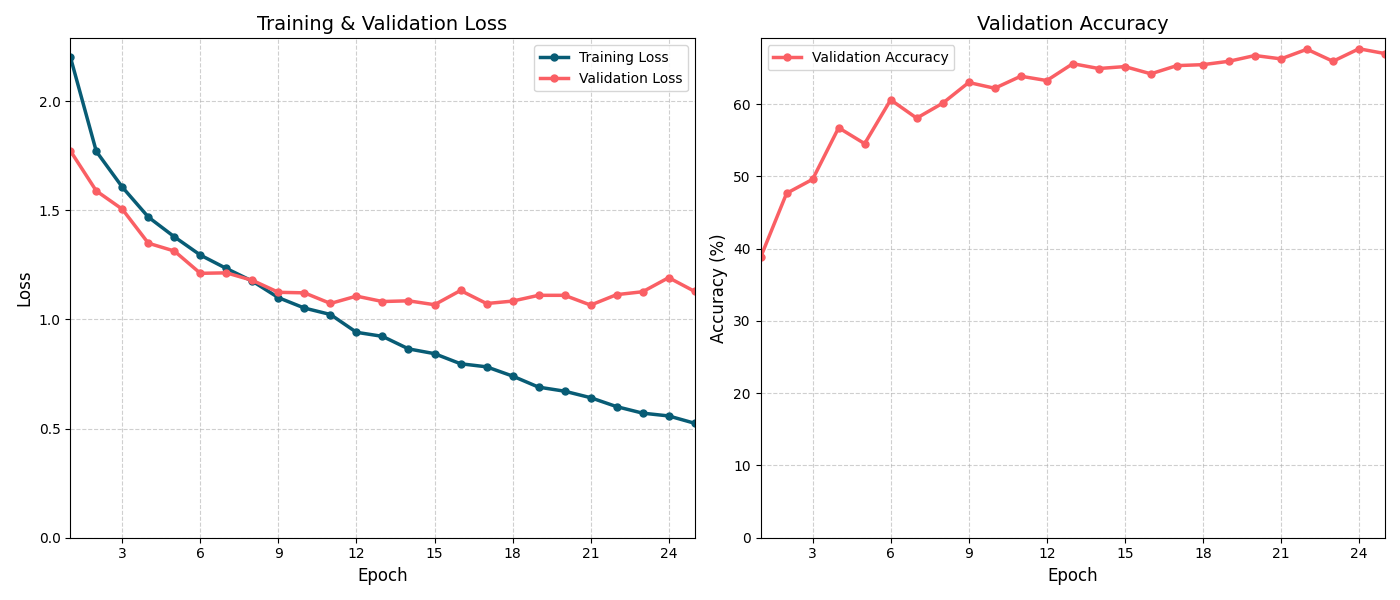

In [ ]:
from IPython.display import Image
Image('./nb_image/lab_1_training_plot.png')

In [ ]:
# Pre-calculated mean for each of the 3 channels of the CIFAR-100 dataset
cifar100_mean = (0.5071, 0.4867, 0.4408)
# Pre-calculated standard deviation for each of the 3 channels of the CIFAR-100 dataset
cifar100_std = (0.2675, 0.2565, 0.2761)

As you learned previously, the training transformation pipeline is where you apply data augmentation. To make your model even more robust, you will add a new technique to your arsenal this time: `RandomVerticalFlip`. While horizontal flipping is common, adding vertical flips can also help the model learn that an object's orientation might not always be upright, a useful feature for classifying things like insects or flowers from various angles.

<a name='ex-1'></a>
### Exercise 1 - define_transformations

Your task is to define two distinct image transformation pipelines using `torchvision.transforms`.

**Your Task**:

* **For `train_transformations`**: Create a composition of transforms for the training dataset.
>
    * This pipeline should include random [horizontal](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html) and [vertical](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomVerticalFlip.html) flips.
    * It should also randomly [rotate](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomRotation.html) the images by up to **15 degrees**.
    * Finally, it must convert images to PyTorch [tensors](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) and [normalize](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html) them using the provided `mean` and `std`.
>
* **For `val_transformations`**: Create a second, simpler pipeline for the validation dataset.
>
    * This pipeline should only perform the two essential steps: converting images to [tensors](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) and [normalizing](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html) them with the same `mean` and `std`.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you're stuck, here is a more detailed breakdown.

You will use `transforms.Compose([...])` to create a list of transformations for both pipelines. All the required functions are part of the `transforms` module.

**For `train_transformations`**:

* You need to create a list of five transformation objects inside `transforms.Compose`.

* The first one is for horizontal flips. The call looks like this: `transforms.RandomHorizontalFlip()`.

* The next two for vertical flips and rotations follow a similar pattern. Remember to pass `15` as the argument for the rotation.

* The last two transformations are:

    * `call the ToTensor method from the transforms module`

    * `call the Normalize method from the transforms module, passing it the mean and std variables`

**For `val_transformations`**:

* This pipeline is much simpler and only contains the last two steps from the training pipeline.

* Your list inside `transforms.Compose` should contain just two items:

    * `first, the transformation to convert an image to a tensor`

    * `second, the transformation to normalize the tensor using the given mean and std`

</details>

In [ ]:
# GRADED FUNCTION: define_transformations

def define_transformations(mean, std):
    """
    Creates image transformation pipelines for training and validation.
    """

    ### START CODE HERE ###

    train_transformations = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    val_transformations = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    ### END CODE HERE ###

    return train_transformations, val_transformations




In [ ]:
# Verify the Transformations
print("--- Verifying define_transformations ---\n")
train_transform_verify, val_transform_verify = define_transformations(cifar100_mean, cifar100_std)


print("Training Transformations:")
print(train_transform_verify)
print("-" * 30)
print("\nValidation Transformations:")
print(val_transform_verify)

--- Verifying define_transformations ---

Training Transformations:
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
)
------------------------------

Validation Transformations:
Compose(
    ToTensor()
    Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
)


#### Expected Output:

```
Training Transformations:
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
)
------------------------------

Validation Transformations:
Compose(
    ToTensor()
    Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
)
```

In [ ]:
# Test your code!
unittests.exercise_1(define_transformations)

 All tests passed!


* Call the `define_transformations` function, passing the `cifar100_mean` and `cifar100_std` as arguments.
* This returns two separate transformation pipelines, which are stored in the `train_transform` and `val_transform` variables for later use.

In [ ]:
# Create and store the training and validation transformation pipelines
train_transform, val_transform = define_transformations(cifar100_mean, cifar100_std)

<a name='1-2'></a>
### 1.2 - Assembling the Data Loaders

With your powerful new transformation pipelines defined, it is time to prepare the data for training. You will first specify the 15 target classes and then use your transformations to load the images and wrap them in `DataLoader` objects, which will feed the data to your model in batches.

* First, define the `all_target_classes` list.
* These are the same classes of flowers, mammals, and insects you worked with in the previous lab, ensuring you are tackling the same classification problem, but with an upgraded pipeline.

In [ ]:
# Define the full class list.
all_target_classes = [
    # Flowers
    'orchid', 'poppy', 'rose', 'sunflower', 'tulip',
    # Mammals
    'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
    # Insects
    'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'
]

* Next, call the `load_cifar100_subset` function, passing in your class list (`all_target_classes`) and both transformation pipelines (`train_transform` and `val_transform`).
* This function handles the entire loading process and returns two PyTorch `Dataset` objects, which are stored in the `train_dataset` and `val_dataset` variables.

In [ ]:
# Load the full datasets.
train_dataset, val_dataset = helper_utils.load_cifar100_subset(all_target_classes, train_transform, val_transform)

Dataset found in './cifar_100'. Loading from local files.
Dataset loaded successfully.

Filtering for 15 classes...
Filtering complete. Returning training and validation datasets.


<br>

With your datasets prepared, the final step is to wrap them in PyTorch's `DataLoader`. This utility is essential for feeding data to your model in manageable batches.

* Create the `train_loader` for your training data.
* Create the `val_loader` for your validation data.

In [ ]:
# Set the number of samples to be processed in each batch
batch_size = 64

# Create a data loader for the training set, with shuffling enabled
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Create a data loader for the validation set, without shuffling
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

<a name='1-3'></a>
### 1.3 - Visualizing the Training Images

It is always a good practice to visualize your data. The following line calls a helper function to display a grid of random images from your `train_loader`.

Pay close attention to the output. Since these images come from the training set, you should see the effects of your data augmentation pipeline in action. Look for images that have been randomly flipped horizontally, vertically, or rotated. This is an excellent way to confirm your transformations are working as expected.

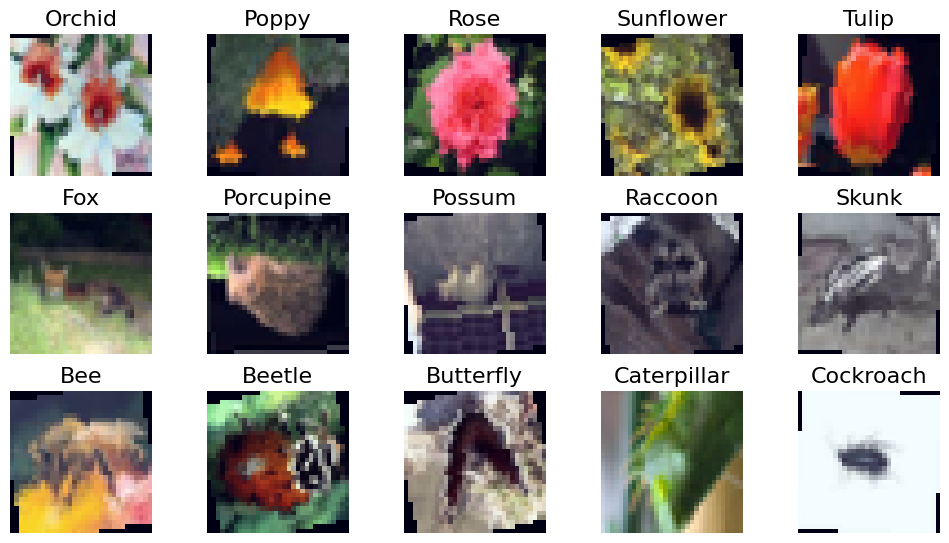

In [ ]:
# Visualize a grid of random training images
helper_utils.visualise_images(train_loader, grid=(3, 5))

<a name='2'></a>
## 2 - Building a Modular and Robust CNN

With a more robust data pipeline in place, your next step is to enhance the model's architecture itself. You will refactor the original CNN to be more modular, efficient, and powerful. This is the next pivotal step toward resolving the overfitting problem and pushing your model's performance to new heights.

<a name='2-1'></a>
### 2.1 - The Power of Modularity: The CNNBlock

In the previous lab, your model's architecture had a repeating pattern of convolution, activation, and pooling layers. Defining these layers individually can become repetitive and makes the model harder to modify. A much better approach is to group these patterns into a single, reusable module. Your first task is to create a `CNNBlock` that packages these layers together. This modular design makes your main model's code significantly cleaner and easier to manage.

<a name='2-1-1'></a>
#### 2.1.1 - <code>[BatchNorm2d Layer](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)</code>

As part of this new, improved block, you will also introduce a powerful new layer: `BatchNorm2d`. This layer is a pivotal technique for building modern, high performing deep neural networks.

Think of Batch Normalization as a traffic controller for the data flowing between your network's layers. After a convolutional layer processes a batch of images, the outputs (or activations) can have widely varying distributions from one batch to the next. `BatchNorm2d` steps in and normalizes these activations within each mini batch, adjusting them to have a consistent mean and standard deviation. It then uses two learnable parameters to scale and shift this normalized output, allowing the network itself to learn the optimal distribution for the data at that point.

This seemingly simple step provides three profound benefits:

* **It Stabilizes and Accelerates Training**: By keeping the distribution of data consistent between layers, it prevents later layers from having to constantly adapt to a shifting input from the layers before them. This stability allows you to use higher learning rates, which can dramatically speed up how quickly your model learns.

* **It Acts as a Regularizer**: Because the normalization statistics are calculated for each unique mini batch, it introduces a slight amount of noise into the training process. This noise makes it harder for the model to perfectly memorize the training data, encouraging it to learn more general features and thus reducing overfitting.

* **It Reduces Sensitivity to Initialization**: The layer makes your model less dependent on the specific random weights it starts with, leading to more reliable and repeatable training results.

By adding `BatchNorm2d` to your `CNNBlock`, you are not just adding another layer; you are fundamentally making your model's training process more stable, efficient, and robust.

<a name='ex-2'></a>
### Exercise 2 - CNNBlock

You will now implement the `CNNBlock` class. This class will package the four layers into a single `nn.Sequential` module.

**Your Task**:

**Inside the `__init__` method**:
> * You need to define a sequential container named `self.block`.
> * Inside this <code>[nn.Sequential](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html)</code> container, you will add the following layers in order:
>    1. A <code>[nn.Conv2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)</code> layer. Use the `in_channels`, `out_channels`, `kernel_size`, and `padding` arguments that are passed to the `__init__` method.
>    2. A <code>[nn.BatchNorm2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)</code> layer. This layer needs to know the number of channels of its input, which is the output of the previous convolutional layer.
>    3. A <code>[nn.ReLU](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)</code> activation function.
>    4. A <code>[nn.MaxPool2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)</code> layer. This will downsample the feature map. You should set both the `kernel_size` and `stride` to `2`.

**Inside the `forward` method**:

> * This method performs the forward pass.
> * Pass the input tensor `x` through the `self.block` you defined and return the result.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you are looking for more guidance, here is a detailed breakdown.

**For the `__init__` method**:

* You are defining a sequence of layers. The entire sequence will be assigned to `self.block`. The structure starts like this: `self.block = nn.Sequential(...)`.

* The layers are provided as arguments to `nn.Sequential`, separated by commas.

* **1. Convolutional Layer**: The first layer is `nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)`. Notice how it uses the parameters from the `__init__` method's signature.

* **2. Batch Norm Layer**: The second layer is `nn.BatchNorm2d(...)`. It needs one argument: the number of channels it will normalize. This is equal to the number of output channels from the previous layer, which is `out_channels`.

* **3. ReLU Layer**: The third layer is simply `nn.ReLU()`. It does not require any arguments.

* **4. Max Pooling Layer**: The final layer is `nn.MaxPool2d(...)`. You need to provide the `kernel_size` and `stride`. The call will look like: `nn.MaxPool2d(kernel_size=2, stride=2)`.

**For the `forward` method**:

* This is a single line of code. You simply need to call the module you created in the `__init__` method on the input tensor.
* The pseudocode would be: `return the result of applying self.block to the input x`.

</details>

In [ ]:
# GRADED CLASS: CNNBlock

# GRADED CLASS: CNNBlock
class CNNBlock(nn.Module):
    """
    Defines a single convolutional block for a CNN.
    This block consists of a convolutional layer, batch normalization,
    a ReLU activation, and a max-pooling layer, bundled as a sequential module.
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        """
        Initializes the layers of the CNNBlock.
        Args:
            in_channels (int): Number of channels in the input image.
            out_channels (int): Number of channels produced by the convolution.
            kernel_size (int, optional): Size of the convolving kernel. Defaults to 3.
            padding (int, optional): Zero-padding added to both sides of the input. Defaults to 1.
        """
        # Initialize the parent nn.Module class.
        super(CNNBlock, self).__init__()

        ### START CODE HERE ###
        # Define the sequential container for the block's layers.
        self.block = nn.Sequential(
            # 2D convolutional layer
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            # Batch normalization
            nn.BatchNorm2d(out_channels),
            # ReLU activation
            nn.ReLU(),
            # Max pooling layer
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        ### END CODE HERE ###

    def forward(self, x):
        """
        Defines the forward pass for the CNNBlock.
        Args:
            x: The input tensor for the block.
        Returns:
            The output tensor after passing through the block.
        """
        ### START CODE HERE ###
        x = self.block(x)
        return x
        ### END CODE HERE ###


        # Pass the input tensor through the sequential block of layers.
        x = __BLANK__
        return x

        ### END CODE HERE ###

In [ ]:
# Verify the CNNBlock
print("--- Verifying CNNBlock ---\n")

# Instantiate the block with 3 input channels and 16 output channels
verify_cnn_block = CNNBlock(in_channels=3, out_channels=16)
print("Block Structure:\n")
print(verify_cnn_block)

# Verify the output shape after a forward pass
# Create a dummy input tensor (batch_size=1, channels=3, height=32, width=32)
dummy_input = torch.randn(1, 3, 32, 32)
print(f"\nInput tensor shape:  {dummy_input.shape}")

# Pass the dummy tensor through the block
output = verify_cnn_block(dummy_input)
print(f"Output tensor shape: {output.shape}")

--- Verifying CNNBlock ---

Block Structure:

CNNBlock(
  (block): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

Input tensor shape:  torch.Size([1, 3, 32, 32])
Output tensor shape: torch.Size([1, 16, 16, 16])


#### Expected Output:

```
Block Structure:

CNNBlock(
  (block): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

Input tensor shape:  torch.Size([1, 3, 32, 32])
Output tensor shape: torch.Size([1, 16, 16, 16])
```

In [ ]:
# Test your code!
unittests.exercise_2(CNNBlock)

 All tests passed!


<a name='2-2'></a>
### 2.2 - Assembling the Full CNN with Modular Blocks
Now that you have a reusable `CNNBlock`, you can assemble your full `SimpleCNN` architecture. By using your new modular block, you will see how much cleaner and more professional your model definition becomes. Instead of defining many individual layers for the convolutional part of your network, you will now define just three `CNNBlock` instances.

Your model will consist of two main parts:

* **A feature extractor**: A sequence of three CNNBlocks that will learn to identify visual patterns in the images.
* **A classifier**: A sequence of fully connected layers that will take the features from the convolutional blocks and make the final prediction.

In this new version, you will also increase the **dropout rate to `0.6`**. This is another important step in your fight against overfitting, as it makes the model less likely to rely on any single feature.

<a name='ex-3'></a>
### Exercise 3 - SimpleCNN

You will now implement the `__init__` and `forward` methods for the `SimpleCNN` class. You will use the `CNNBlock` you just built as the primary component of the network's body.

**Your Task**:

**Inside the `__init__` method**:

> * **Feature Extractor**:
>
>    * Instantiate three `CNNBlock` layers (`conv_block1`, `conv_block2`, `conv_block3`).
>    * The first block should take an input with **3 channels** (for RGB images) and produce **32 output channels**.
>    * For the subsequent blocks, the number of input channels must match the number of output channels from the previous block. You will double the number of channels at each step `(3 -> 32 -> 64 -> 128)`.

> * **Classifier**:
>
>    * Define a `self.classifier` using an `nn.Sequential` container.
>    * This container should have the following layers in order:
>        1. An <code>[nn.Flatten](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html)</code> layer to transform the 2D feature map into a 1D vector.
>        2. An <code>[nn.Linear](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)</code> layer. You must calculate the correct number of input features. This depends on the output shape of the last `CNNBlock`. The output size of this layer should be **512**.
>        3. An `nn.ReLU` activation.
>        4. An <code>[nn.Dropout](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)</code> layer with a rate of `0.6` to help prevent overfitting.
>        5. A final `nn.Linear` layer that maps the **512 features** to the **number of output classes**.

**Inside the `forward` method**:
>
>    * Define the data flow through the network.
>    * Pass the input `x` sequentially through `conv_block1`, then `conv_block2`, and then `conv_block3`.
>    * Finally, pass the output of the last convolutional block through your `classifier`.
>    * Return the final output.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you are stuck, here is a more detailed breakdown for the implementation.

**For the `__init__` method**:

* **Convolutional Blocks**:
>    
    * The first block is a straightforward instantiation: `self.conv_block1 = CNNBlock(in_channels=3, out_channels=32)`.
    * For the second block, the `in_channels` must be `32` (the `out_channels` of the first). The `out_channels` will be `64`. Follow this pattern for the third block.
>
* **Classifier**:

    * Start by defining the sequential container: `self.classifier = nn.Sequential(...)`
    **1. Flatten Layer**: The first layer is `nn.Flatten()`. It takes no arguments.
    **2. First Linear Layer**: This is `nn.Linear(in_features=..., out_features=512)`.
        * To find the `in_features`, you need to calculate the size of the flattened tensor. The input images are 32x32. Each `CNNBlock` contains a `MaxPool2d` layer with a stride of 2, which halves the height and width. After three blocks, the dimensions will be `32 → 16 → 8 → 4`.
        * The last `CNNBlock` outputs 128 channels. So, the total number of features is `128 * 4 * 4`.
    **3. ReLU Layer**: Add `nn.ReLU()`.
    **4. Dropout Layer**: Add `nn.Dropout(0.6)`.
    **5. Final Linear Layer**: This is `nn.Linear(in_features=512, out_features=num_classes)`.

**For the `forward` method**:
>
* This method describes how data flows from input to output. You can use the same variable `x` and reassign it after each step.
* The pseudocode for the sequence is:
    * `x = pass the input x through self.conv_block1`
    * `x = pass the new x through self.conv_block2`
    * `x = pass the new x through self.conv_block3`
    * `x = pass the final feature map through self.classifier`
* Finally, return `x`.

</details>

In [ ]:
# GRADED CLASS: SimpleCNN
class SimpleCNN(nn.Module):
    """
    Defines a simple CNN architecture using modular CNNBlocks.
    This model stacks three reusable convolutional blocks followed by a fully
    connected classifier to perform image classification.
    """
    def __init__(self, num_classes):
        """
        Initializes the layers of the SimpleCNN model.
        Args:
            num_classes (int): The number of output classes for the classifier.
        """
        super(SimpleCNN, self).__init__()

        ### START CODE HERE ###
        # Define the first convolutional block.
        self.conv_block1 = CNNBlock(in_channels=3, out_channels=32)

        # Define the second convolutional block.
        self.conv_block2 = CNNBlock(in_channels=32, out_channels=64)

        # Define the third convolutional block.
        self.conv_block3 = CNNBlock(in_channels=64, out_channels=128)

        # Define the fully connected classifier block.
        self.classifier = nn.Sequential(
            # Flatten the 3D feature map (channels, height, width) into a 1D vector.
            nn.Flatten(),
            # First fully connected (linear) layer that maps the flattened features to a hidden layer.
            nn.Linear(128 * 4 * 4, 512),
            # ReLU activation function to introduce non-linearity.
            nn.ReLU(),
            # Dropout layer to prevent overfitting by randomly setting a fraction of inputs to zero.
            nn.Dropout(0.6),
            # Final fully connected (linear) layer that maps the hidden layer to the output classes.
            nn.Linear(512, num_classes)
        )
        ### END CODE HERE ###

    def forward(self, x):
        """
        Defines the forward pass of the SimpleCNN model.
        Args:
            x (torch.Tensor): The input tensor containing a batch of images.
        Returns:
            torch.Tensor: The output tensor with logits for each class.
        """
        ### START CODE HERE ###
        # Pass the input through the first convolutional block.
        x = self.conv_block1(x)

        # Pass the result through the second convolutional block.
        x = self.conv_block2(x)

        # Pass the result through the third convolutional block.
        x = self.conv_block3(x)

        # Pass the final feature map through the classifier.
        x = self.classifier(x)
        ### END CODE HERE ###

        return x


In [ ]:
# Verify the SimpleCNN
print("--- Verifying SimpleCNN ---\n")

# Verify the structure of the model
# Instantiate the model with 15 output classes
verify_simple_cnn = SimpleCNN(num_classes=15)
print("Model Structure:\n")
print(verify_simple_cnn)

# Verify the output shape after a forward pass
# Create a dummy input tensor (batch_size=64, channels=3, height=32, width=32)
dummy_input = torch.randn(64, 3, 32, 32)
print(f"\nInput tensor shape:  {dummy_input.shape}")

# Pass the dummy tensor through the model
output = verify_simple_cnn(dummy_input)
print(f"Output tensor shape: {output.shape}")

--- Verifying SimpleCNN ---

Model Structure:

SimpleCNN(
  (conv_block1): CNNBlock(
    (block): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_block2): CNNBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_block3): CNNBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2,

#### Expected Output:

```
Model Structure:

SimpleCNN(
  (conv_block1): CNNBlock(
    (block): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_block2): CNNBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_block3): CNNBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
    (4): Linear(in_features=512, out_features=15, bias=True)
  )
)

Input tensor shape:  torch.Size([64, 3, 32, 32])
Output tensor shape: torch.Size([64, 15])
```

<br>

**NOTE**: The test below evaluates your `SimpleCNN` class, which internally uses the `CNNBlock` you implemented in the previous exercise. If you did not pass the test for `Exercise 2 - CNNBlock`, running the following cell will likely return an error. Please make sure your `CNNBlock` implementation is correct first!

In [ ]:
# Test your code!
unittests.exercise_3(SimpleCNN, CNNBlock)

 All tests passed!


<br>

With your `SimpleCNN` class defined, the next step is to create an instance of the model.

* First, dynamically determine the number of classes by getting the length of the `.classes` attribute from your `train_dataset`.
* Next, create an instance of your `SimpleCNN` model, passing the `num_classes` variable to its constructor. This ensures the final layer of your model is correctly sized for your 15-class problem.

In [ ]:
# Get the number of classes
num_classes = len(train_dataset.classes)

# Instantiate the model
model = SimpleCNN(num_classes)

<a name='3'></a>
## 3 - Training the Upgraded Model
With your upgraded data pipeline and modular CNN architecture complete, you are ready to begin the training process. In this section, you will configure the final pieces of your training pipeline: the loss function and the optimizer. Then, you will implement the core training and validation logic that will run your experiment and reveal how well your new model performs.

<a name='3-1'></a>
### 3.1 - Configuring the Loss and Optimizer

Before you can train the model, you must define two key components: a loss function to measure error and an optimizer to update the model's weights.

* For the loss function, you will continue to use `nn.CrossEntropyLoss`, the standard choice for multi-class classification.
>
* For the optimizer, you will use `Adam`, but with an important addition to combat overfitting: `weight_decay`.
    * Weight decay adds a penalty to the loss function based on the magnitude of the model's weights. It encourages the network to learn smaller, simpler weight values, which makes it more robust and less likely to memorize the training data. This is another vital tool for improving your model's ability to generalize.

In [ ]:
# Loss function
loss_function = nn.CrossEntropyLoss()

# Optimizer for the model with weight_decay
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0005)

<a name='3-2'></a>
### 3.2 - Implementing the Training and Validation Logic

You will now implement the core logic for training and evaluating your model. This will be done in two separate functions:

* `train_epoch`: To perform a single pass over the training data to update the model.
* `validate_epoch`: To perform a single pass over the validation data to measure performance.

<a name='ex-4'></a>
### Exercise 4 -  train_epoch

Your task is to complete the core training logic within the `for` loop of the `train_epoch` function. You will implement the five fundamental steps of a single training iteration.

**Your Task**:

Inside the `train_epoch` function, for each batch of `images` and `labels`:

* **Clear Gradients**:
    * Before computing the gradients for the current batch, you must clear any gradients that were stored from the previous batch.
* **Forward Pass**:
    * Feed the `images` through the `model` to get the output predictions.
* **Calculate Loss**:
    * Use the provided `loss_function` to measure the difference between the model's `outputs` and the true `labels`.
* **Backward Pass**:
    * Compute the gradients of the loss with respect to all the model's parameters. This is also known as backpropagation.
* **Update Parameters**:
    * Use the `optimizer` to adjust the model's parameters based on the gradients you just computed.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you need some help, here is a more direct guide for each step.

* **Clear Gradients**: This is done to prevent the accumulation of gradients across batches.
    * The pseudocode is: `call the zero_grad() method on the optimizer`.
>
* **Forward Pass**: This is how you get the model's predictions for the current batch.
    * The pseudocode is: `outputs = call the model, passing the images as the argument`.
>
* **Calculate Loss**: You compare the model's predictions with the actual ground truth labels.
    * The pseudocode is: `loss = call the loss_function, passing the outputs and labels as arguments`.
>
* **Backward Pass**: This step calculates how much each model parameter contributed to the overall loss.
    * The pseudocode is: `call the backward() method on the loss tensor`.
>    
* **Update Parameters**: The optimizer uses the calculated gradients to take a small step in the direction that minimizes the loss.
    * The pseudocode is: `call the step() method on the optimizer`.

</details>

In [ ]:
# GRADED FUNCTION: train_epoch
def train_epoch(model, train_loader, loss_function, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        ### START CODE HERE ###
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        ### END CODE HERE ###

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss


In [ ]:
# Use a helper function to perform a sanity check on the train_epoch implementation
helper_utils.verify_training_process(SimpleCNN, train_loader, loss_function, train_epoch, device)

--- Verifying train_epoch (training for 5 epochs) ---

Training on 640 images for 5 epochs:

Epoch [1/5], Loss: 2.7081
Epoch [2/5], Loss: 2.3306
Epoch [3/5], Loss: 2.0609
Epoch [4/5], Loss: 1.8942
Epoch [5/5], Loss: 1.7735

Weight Update Check:	Model weights changed during training.
Loss Trend Check:	Loss decreased from 2.7081 to 1.7735.


#### Expected Output (Approximately):

```
Training on 640 images for 5 epochs:

Epoch [1/5], Loss: 2.6735
Epoch [2/5], Loss: 2.3238
Epoch [3/5], Loss: 2.0528
Epoch [4/5], Loss: 1.8341
Epoch [5/5], Loss: 1.7676

Weight Update Check:	Model weights changed during training.
Loss Trend Check:	Loss decreased from 2.6735 to 1.7676.
```

In [ ]:
# Test your code!
unittests.exercise_4(train_epoch)

 All tests passed!


<a name='ex-5'></a>
### Exercise 5 - validate_epoch

Your task is to complete the validation logic. This involves performing a forward pass and then calculating both the loss and the number of correct predictions to determine the accuracy.

**Your Task**:

* **Disable Gradient Calculation**:
>
    * Wrap the entire for loop within the `torch.no_grad()` context manager. This tells PyTorch not to compute gradients, which saves memory and computation time during validation.
>
* **Inside the `for` loop**:
>
    * **Forward Pass**:
        * Just like in training, pass the `images` through the `model` to get its `outputs`.        
    * **Calculate Loss**:
        * Use the `loss_function` to compute the `val_loss` between the `outputs` and the true `labels`.
    * **Accumulate Loss**:
        * Add the batch's loss to the `running_val_loss`. Remember to get the scalar value from the loss tensor and scale it by the batch size.
    * **Get Predictions**:
        * Determine the model's predicted class for each image in the batch. The `outputs` from your model are raw scores (logits). The class with the highest score is the model's prediction. You need to find the index of this maximum score.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you need a bit more direction, here is a detailed guide.

**Disable Gradient Calculation**:
>
This is a context manager in PyTorch. The structure you need is `with torch.no_grad()`:. The for loop should be indented inside this block.

**Inside the for loop**:
   
* **Forward Pass**: This is identical to the training loop. The pseudocode is: `outputs = call the model, passing the images as the argument`.

* **Calculate Loss**: This is also the same as in the training loop. The pseudocode is: `val_loss = call the loss_function, passing the outputs and labels as arguments`.

* **Accumulate Loss**: You need to update the `running_val_loss`. The pseudocode is: `running_val_loss += get the scalar value of val_loss using the .item() method * the number of images in the current batch`.

* **Get Predictions**: You need to find the most likely class from the output logits.

    * The `torch.max()` function is perfect for this. You need to call it on the `outputs` tensor along dimension 1 (the class dimension).

    * The pseudocode is: `_, predicted = use torch.max() on the outputs tensor, specifying dimension 1`.

    * Note that `torch.max()` returns a tuple of (max_values, max_indices). You only need the second element, the indices, which correspond to the predicted class labels.

</details>

In [ ]:
# GRADED FUNCTION: validate_epoch
def validate_epoch(model, val_loader, loss_function, device):
    """
    Performs a single validation epoch.
    """
    # Set the model to evaluation mode
    model.eval()

    running_val_loss = 0.0
    correct = 0
    total = 0

    ### START CODE HERE ###
    # Disable gradient calculations for validation
    with torch.no_grad():
    ### END CODE HERE ###

        # Iterate over batches of data in the validation loader
        for images, labels in val_loader:
            # Move images and labels to the specified device
            images, labels = images.to(device), labels.to(device)

            ### START CODE HERE ###
            # Perform a forward pass to get model outputs
            outputs = model(images)

            # Calculate the validation loss for the batch
            val_loss = loss_function(outputs, labels)

            # Accumulate the validation loss
            running_val_loss += val_loss.item() * images.size(0)

            # Get the predicted class labels
            _, predicted = torch.max(outputs, 1)
            ### END CODE HERE ###

            # Update the total number of samples
            total += labels.size(0)
            # Update the number of correct predictions
            correct += (predicted == labels).sum().item()

    # Calculate the average validation loss and accuracy for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_accuracy = 100.0 * correct / total

    return epoch_val_loss, epoch_accuracy


In [ ]:
# Use a helper function to perform a sanity check on the validate_epoch implementation
helper_utils.verify_validation_process(SimpleCNN, val_loader, loss_function, validate_epoch, device)

--- Verifying validate_epoch ---

Validating on 640 images:

Returned Validation Loss: 2.7070
Returned Validation Accuracy: 7.19%


Return Types Check:	Function returned a float for loss and accuracy.
Weight Integrity Check:	Model weights were not changed during validation.


#### Expected Output:

```
Return Types Check:	Function returned a float for loss and accuracy.
Weight Integrity Check:	Model weights were not changed during validation.
```

In [ ]:
# Test your code!
unittests.exercise_5(validate_epoch)

 All tests passed!


---
# Submission Note

Congratulations! You've completed the final graded exercise of this assignment.

If you've successfully passed all the unit tests above, you've completed the core requirements of this assignment.

---

With the individual functions for training and validation complete, you can now bring them together in the main `training_loop`. This function orchestrates the entire training process over a set number of epochs and includes a pivotal upgrade.

A common challenge is that a model's performance can peak and then decline if training continues for too long. To address this, the `training_loop` will:

* **Monitor** the validation accuracy at the end of each epoch.
* **Keep track** of the best performing model state seen so far.
* After the final epoch, it automatically **returns the model from its single best epoch**.

This guarantees that you always get back the version of your model that achieved the highest validation accuracy during the entire training run.

In [ ]:
def training_loop(model, train_loader, val_loader, loss_function, optimizer, num_epochs, device):
    """
    Trains and validates a PyTorch neural network model.

    Args:
        model (torch.nn.Module): The model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
        loss_function (callable): The loss function.
        optimizer (torch.optim.Optimizer): The optimization algorithm.
        num_epochs (int): The total number of epochs to train for.
        device (torch.device): The device (e.g., 'cuda' or 'cpu') to run training on.

    Returns:
        tuple: A tuple containing the best trained model and a list of metrics
               (train_losses, val_losses, val_accuracies).
    """
    # Move the model to the specified device (CPU or GPU)
    model.to(device)

    # Initialize variables to track the best performing model
    best_val_accuracy = 0.0
    best_model_state = None
    best_epoch = 0

    # Initialize lists to store training and validation metrics
    train_losses, val_losses, val_accuracies = [], [], []

    print("--- Training Started ---")

    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        # Perform one epoch of training
        epoch_loss = train_epoch(model, train_loader, loss_function, optimizer, device)
        train_losses.append(epoch_loss)

        # Perform one epoch of validation
        epoch_val_loss, epoch_accuracy = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_accuracy)

        # Print the metrics for the current epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_accuracy:.2f}%")

        # Check if the current model is the best one so far
        if epoch_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_accuracy
            best_epoch = epoch + 1
            # Save the state of the best model in memory
            best_model_state = copy.deepcopy(model.state_dict())

    print("--- Finished Training ---")

    # Load the best model weights before returning
    if best_model_state:
        print(f"\n--- Returning best model with {best_val_accuracy:.2f}% validation accuracy, achieved at epoch {best_epoch} ---")
        model.load_state_dict(best_model_state)

    # Consolidate all metrics into a single list
    metrics = [train_losses, val_losses, val_accuracies]

    # Return the trained model and the collected metrics
    return model, metrics

Everything is now in place. The following code will call your `training_loop` function to kick off the full training and validation process.

The model will train for **50 epochs**. With the powerful regularization techniques you have added (Batch Normalization, increased Dropout, and Weight Decay) and a smaller learning rate, the model is designed to learn more cautiously. This longer training run gives the model sufficient time to converge to a robust, generalized solution.

--- Training Started ---
Epoch [1/50], Train Loss: 2.1659, Val Loss: 1.7555, Val Accuracy: 38.73%
Epoch [2/50], Train Loss: 1.8262, Val Loss: 1.6122, Val Accuracy: 45.60%
Epoch [3/50], Train Loss: 1.7030, Val Loss: 1.5518, Val Accuracy: 45.93%
Epoch [4/50], Train Loss: 1.6159, Val Loss: 1.4949, Val Accuracy: 50.20%
Epoch [5/50], Train Loss: 1.5680, Val Loss: 1.3992, Val Accuracy: 52.87%
Epoch [6/50], Train Loss: 1.5114, Val Loss: 1.3616, Val Accuracy: 54.40%
Epoch [7/50], Train Loss: 1.4715, Val Loss: 1.3350, Val Accuracy: 52.93%
Epoch [8/50], Train Loss: 1.4275, Val Loss: 1.3019, Val Accuracy: 54.60%
Epoch [9/50], Train Loss: 1.3787, Val Loss: 1.2518, Val Accuracy: 58.07%
Epoch [10/50], Train Loss: 1.3668, Val Loss: 1.3092, Val Accuracy: 55.80%
Epoch [11/50], Train Loss: 1.3333, Val Loss: 1.2303, Val Accuracy: 60.27%
Epoch [12/50], Train Loss: 1.3238, Val Loss: 1.2215, Val Accuracy: 60.20%
Epoch [13/50], Train Loss: 1.2739, Val Loss: 1.1912, Val Accuracy: 60.87%
Epoch [14/50], Train L

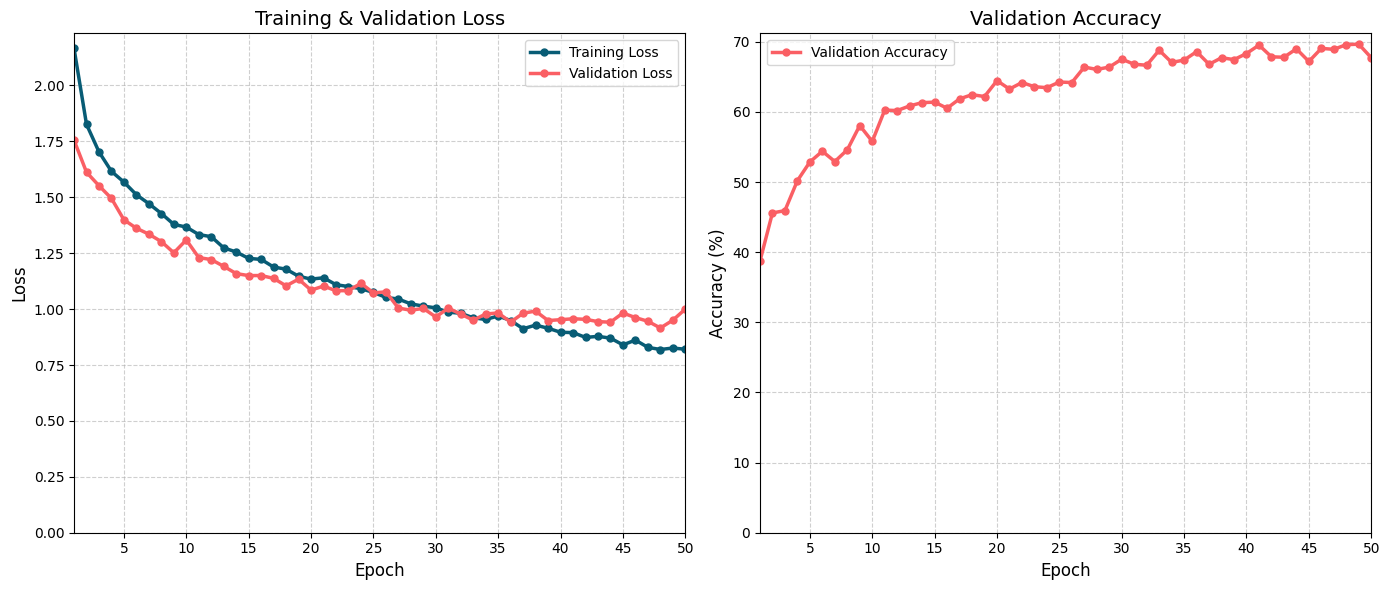

In [ ]:
# Start the training process by calling the training loop function
trained_model, training_metrics = training_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer,
    num_epochs=50,
    device=device
)

# Visualize the training metrics (loss and accuracy)
print("\n--- Training Plots ---\n")
helper_utils.plot_training_metrics(training_metrics)

**Analyzing the Results**

Take a close look at the new training plots and compare them to the ones from the previous lab. The difference is remarkable.

The training and validation loss curves now follow each other very closely, and the wide gap that signaled overfitting is gone. The validation accuracy shows a much healthier, more consistent climb. This is clear evidence that you have successfully solved the overfitting problem! The combination of more data augmentation, Batch Normalization, and Weight Decay worked together to create a model that generalizes far better than before.

**The Performance Plateau**

Your model's validation accuracy now peaks somewhere around 70%, which is a solid result. You might wonder, however, why it did not achieve 90% or higher, especially with all these advanced techniques and longer training. The answer lies in how effectively you have used the tools available to you.

The fundamentals you have learned in this course provide a solid foundation for building deep learning models. The techniques now at your disposal, from data augmentation to modular design and regularization, are powerful. Applying them correctly is precisely what allowed you to solve the initial overfitting problem and achieve this strong result. This demonstrates that you are pushing the limits of what can be accomplished with this foundational toolkit.

You have achieved something significant. You started by building a simple CNN that suffered from a common and challenging problem, and you systematically upgraded your entire pipeline with professional techniques to create this final, robust model. Congratulations on a successful result!

<a name='4'></a>
## 4 - Beyond the Foundations: A Glimpse into the Next Level

You have successfully taken a simple CNN, diagnosed its flaws, and systematically upgraded it into a robust, well-generalized model. You have pushed the foundational toolkit you've learned to its limits to achieve a strong result.

**But what if this isn't the limit? What if there was another way?**

**What if you could take your model's accuracy from around 70% to over 80% on this exact same dataset?**

Take a look at the results from a different, more powerful training strategy. Run the next cell to see that in action.

In [ ]:
# Import the preview function that demonstrates concepts from the next course
from c2_preview.c2_preview import course_2_preview

# This helper function runs a training loop using a powerful strategy that will be taught
# in the next course. Run this cell to see the improved results in action.
trained_model = course_2_preview(
    train_dataset,
    val_dataset,
    loss_function,
    device,
    num_epochs=5
    )

<br>

Incredible, right? In just **5 epochs**, the validation accuracy soared past 80%, a level of performance your previous model did not reach even after 50 epochs.

**How is such a rapid and dramatic improvement possible on the exact same data?**

This result was achieved by combining several powerful, next-level techniques that you will master in the upcoming course. This was just a preview, but the strategy involved three key upgrades:

* **Using a Pre-trained Model**: This is the most significant change. Instead of starting from scratch with random weights, this approach uses a sophisticated model that has already been trained on millions of images. It already possesses a deep understanding of visual patterns, which you can then fine-tune for your specific task.

* **Dynamic Learning Rate Scheduling**: Rather than using a single, fixed learning rate, this strategy uses a *learning rate scheduler*. This tool intelligently adjusts the learning rate during training, making larger updates at the beginning and smaller, more precise adjustments as the model gets closer to the best solution.

* **More Advanced Transformations**: The data augmentation pipeline used for this preview was also more advanced. It included techniques tailored specifically for these high performance models, ensuring the network learned from a richer and more challenging set of training examples.

These concepts are just a glimpse of what comes next. You have built an incredible foundation, and now you are ready to learn the strategies that professionals use to achieve state of the art results quickly and efficiently.

## Conclusion

Congratulations on completing this assignment!

You have successfully navigated a complete and realistic machine learning workflow. You began with a model that suffered from overfitting, diagnosed the problem, and then systematically applied a series of powerful, professional techniques to solve it. You have not just improved a model; you have learned a repeatable process for refining and strengthening any neural network you build in the future.

The skills you practiced here, modular design, implementing regularization, and analyzing training dynamics, are fundamental to building effective deep learning models. You have moved beyond the basics and are now equipped with the practical knowledge needed to tackle more complex, real world problems. Well done!